In [2]:
import numpy as np
import math
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer, assemble, transpile
from qiskit.providers.aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Statevector

In [3]:
def run_with_aer_sim(qc, memory=0):
    backend = AerSimulator(max_memory_mb=memory)
    qobj = assemble(transpile(qc, backend))
    result = backend.run(qobj).result()
    return result

## QROM

In [182]:
def qrom(database, name="db"):
    # Check if database is binary
    assert ((database == 0) | (database == 1)).all()
    
    def encode_row(i):
        row = database[i]
        for j in range(len(row)):
            if row[j] == 1:
                qc.mct(addr_qreg, data_qreg[j])

    def bit_diff_pos(a, b):
        return (addrs[i] ^ addrs[i-1]).bit_length() - 1

    def grey_code(n):
        return n ^ (n >> 1)
    
    nrows, ncols = database.shape
    addr_size = math.ceil(math.log2(nrows))
    addrs = [grey_code(n) for n in range(nrows)]
    
    addr_qreg = QuantumRegister(addr_size, name=f"{name}-address")
    data_qreg = QuantumRegister(ncols, name=f"{name}-data")
    
    qc = QuantumCircuit(addr_qreg, data_qreg)
    
    qc.x(addr_qreg)
    encode_row(0)
    
    qc.barrier()
    
    for i in range(1, len(addrs)):
        qc.x(addr_qreg[bit_diff_pos(addrs[i], addrs[i-1])])
        encode_row(addrs[i])
        qc.barrier()
        
    # TODO remove this, temp hack for 16x16 matrices
    qc.x(addr_qreg[0])
    qc.x(addr_qreg[1])
    
    qc.name = name
    
    return qc

## Inner Product (out of place)

In [5]:
def inner_product(reg_sz, name="dot"):
    a = QuantumRegister(reg_sz, name=f"{name}_a")
    b = QuantumRegister(reg_sz, name=f"{name}_b")
    out = QuantumRegister(1, name=f"{name}_out")

    qc = QuantumCircuit(a, b, out)
    
    for i in range(reg_sz):
        qc.mct([a[i], b[i]], out)
        
    qc.name = name
    
    return qc

## Grover Search

In [6]:
from qiskit.algorithms import AmplificationProblem, Grover

In [16]:
good_state = ['11']

oracle = QuantumCircuit(2)
oracle.cz(0, 1)

problem = AmplificationProblem(oracle, is_good_state = good_state)

problem.grover_operator.decompose().draw()

global phase: π
            ┌───┐┌───┐          ┌───┐┌───┐     
state_0: ─■─┤ H ├┤ X ├───────■──┤ X ├┤ H ├─────
          │ ├───┤├───┤┌───┐┌─┴─┐├───┤├───┤┌───┐
state_1: ─■─┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├
            └───┘└───┘└───┘└───┘└───┘└───┘└───┘

In [17]:
sim = Aer.get_backend("aer_simulator")
grover = Grover(quantum_instance=sim)
result = grover.amplify(problem)
print(result.oracle_evaluation)
result.top_measurement

True


'11'

In [7]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "diffuser"
    return U_s

In [207]:
# A = np.array([[1, 1], [0, 1]])
# y = np.array([0, 1])
# z = np.array([1, 0])

# A = np.array([
#     [0, 1, 0, 0],
#     [1, 1, 1, 0],
#     [1, 0, 1, 1],
#     [1, 1, 1, 0]
# ])
# y = np.array([
#     0,
#     1,
#     1,
#     0
# ])
# z = np.array([
#     1,
#     0,
#     1,
#     1
# ])

# A = np.array([
#     [0, 1, 1, 1, 1, 0, 0, 0],
#     [0, 0, 0, 0, 0, 0, 0, 0],
#     [1, 1, 0, 1, 1, 0, 0, 1],
#     [1, 0, 0, 0, 1, 0, 1, 0],
#     [1, 0, 0, 1, 0, 0, 0, 1],
#     [1, 1, 1, 1, 1, 1, 1, 1],
#     [1, 0, 0, 1, 0, 0, 1, 1],
#     [0, 1, 1, 1, 0, 1, 0, 0]
# ])
# y = np.array([1, 1, 1, 0, 1, 0, 1, 0])
# z = A@y % 2
# z[0] = not z[0]

A = np.random.randint(0, 2, (64, 64))
y = np.random.randint(0, 2, (64,))
z = A@y % 2
z[0] = not z[0]
z[15] = not z[15]
z[32] = not z[32]
z[33] = not z[33]
z[60] = not z[60]
z[62] = not z[62]

In [208]:
num_solutions = (A@y % 2 != z).sum()
num_solutions

6

In [209]:
db = np.concatenate((A, z.reshape((1, -1)).T), axis=1)
nrows, ncols = A.shape
addr_size = math.ceil(math.log2(nrows))

addr_qreg = QuantumRegister(addr_size, name="address")
A_qreg = QuantumRegister(ncols, name="a")
y_qreg = QuantumRegister(nrows, name="y")
z_qreg = QuantumRegister(1, name="z")

data_out = ClassicalRegister(addr_size, name="data")

qc = QuantumCircuit(addr_qreg, A_qreg, y_qreg, z_qreg, data_out)

def encode_vector(qc, qreg, vec):
    a = vec.reshape(-1)
    
    for i in range(len(a)):
        if a[i] == 1:
            qc.x(qreg[i])

qc.h(addr_qreg)
encode_vector(qc, y_qreg, y)
qc.barrier()

qdb = qrom(db)
dot = inner_product(ncols)

if num_solutions == 0:
    num_iterations = 1
else:
    num_iterations = Grover.optimal_num_iterations(num_solutions, addr_size)

print("Number of iterations =", num_iterations)
    
for i in range(num_iterations):
    qc.append(qdb, [*addr_qreg, *A_qreg, *z_qreg])
    qc.append(dot, [*A_qreg, *y_qreg, *z_qreg])
    
#     s1 = Statevector.from_instruction(qc).to_dict()

    qc.z(z_qreg)
    
    qc.append(dot.inverse(), [*A_qreg, *y_qreg, *z_qreg])
    qc.append(qdb.inverse(), [*addr_qreg, *A_qreg, *z_qreg])
    
#     s2 = Statevector.from_instruction(qc).to_dict()

    qc.barrier()
    
    qc.append(diffuser(addr_size), [*addr_qreg])
qc.barrier()

qc.measure([*addr_qreg], data_out)

# print(s1)
# print(s2)

qc.draw(fold=-1)

Number of iterations = 2


┌───┐ ░ ┌──────┐                            ┌─────────┐ ░ ┌───────────┐┌──────┐                            ┌─────────┐ ░ ┌───────────┐ ░ ┌─┐                                                                                                                                                                                                                  
address_0: ┤ H ├─░─┤0     ├────────────────────────────┤0        ├─░─┤0          ├┤0     ├────────────────────────────┤0        ├─░─┤0          ├─░─┤M├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
           ├───┤ ░ │      │                            │         │ ░ │           ││      │                            │         │ ░ │           │ ░ └╥┘┌─┐                                                                                                                                                                                                               
address_1: ┤ H ├─░─┤1     ├────────────────────────────┤1        ├─░─┤1          ├┤1     ├────────────────────────────┤1        ├─░─┤1          ├─░──╫─┤M├───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
           ├───┤ ░ │      │                            │         │ ░ │           ││      │                            │         │ ░ │           │ ░  ║ └╥┘┌─┐                                                                                                                                                                                                            
address_2: ┤ H ├─░─┤2     ├────────────────────────────┤2        ├─░─┤2          ├┤2     ├────────────────────────────┤2        ├─░─┤2          ├─░──╫──╫─┤M├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
           ├───┤ ░ │      │                            │         │ ░ │  diffuser ││      │                            │         │ ░ │  diffuser │ ░  ║  ║ └╥┘┌─┐                                                                                                                                                                                                         
address_3: ┤ H ├─░─┤3     ├────────────────────────────┤3        ├─░─┤3          ├┤3     ├────────────────────────────┤3        ├─░─┤3          ├─░──╫──╫──╫─┤M├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
           ├───┤ ░ │      │                            │         │ ░ │           ││      │                            │         │ ░ │           │ ░  ║  ║  ║ └╥┘┌─┐                                                                                                                                                                                                      
address_4: ┤ H ├─░─┤4     ├────────────────────────────┤4        ├─░─┤4          ├┤4     ├────────────────────────────┤4        ├─░─┤4          ├─░──╫──╫──╫──╫─┤M├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
           ├───┤ ░ │      │                            │         │ ░ │           ││      │                            │         │ ░ │           │ ░  ║  ║  ║  ║ └╥┘┌─┐                                                                                                                                                                                                   
address_5: ┤ H ├─░─┤5     ├──

In [210]:
backend = AerSimulator(method="matrix_product_state")
qobj = assemble(transpile(qc, backend))
result = backend.run(qobj).resutlt()

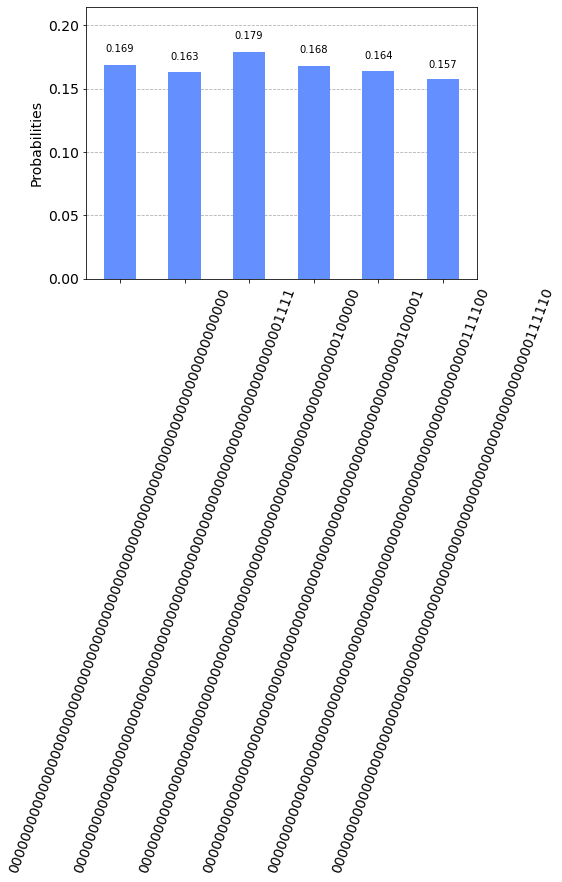

In [211]:
plot_histogram(result.get_counts())

In [203]:
Grover.optimal_num_iterations(5, 6)

2